# TP3 : WEEEU WEEEU, ceci est une descente de police !

Aujourd'hui, nouveau cas concret de l'utilisation de la vision par ordinateur : la reconnaissance d'empreintes. Le commissariat de police du 99ème district de Brooklyn a besoin de votre aide sur une nouvelle scène de crime. Les experts ont pu prélever plusieurs empreintes sur divers objets, et vous avez pour objectif de retrouver l'identité des coupables.

Pour cela, vous avez à votre disposition les empreintes à analyser prise sur la scène de crime (dossier Images_suspects), ainsi qu'une base de données d'empreintes du FBI (dossier DB_FBI). A vous de jouer !

---


## 1) C'est pas un bug, c'est une feature

Dans un premier temps, vous allez écrire le code pour détecter les minutiaes des empreintes de doigt. Les minutiae sont des caractéristiques spécifiques d'une empreinte qui permettent ensuite d'identifier l'individu.

Pour ce TP, vous détecterez 2 types de miniutiaes : 
- Les terminaisons (a) 
- Les bifurcations (b)

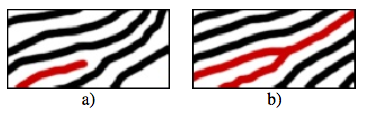

Pour cela, plusieurs étapes sont nécessaires, mais on va faire ça ensemble. Vous allez traiter dans un premier temps les images de la base de données *DB_FBI*, où les images ont déjà été traitées et binarisées en amont.

a) Commençons avec la base de la base : chargez les libraries nécessaires pour ce TP, puis les images de la base de données DB_FBI. Affichez ensuite quelques images de cette base.

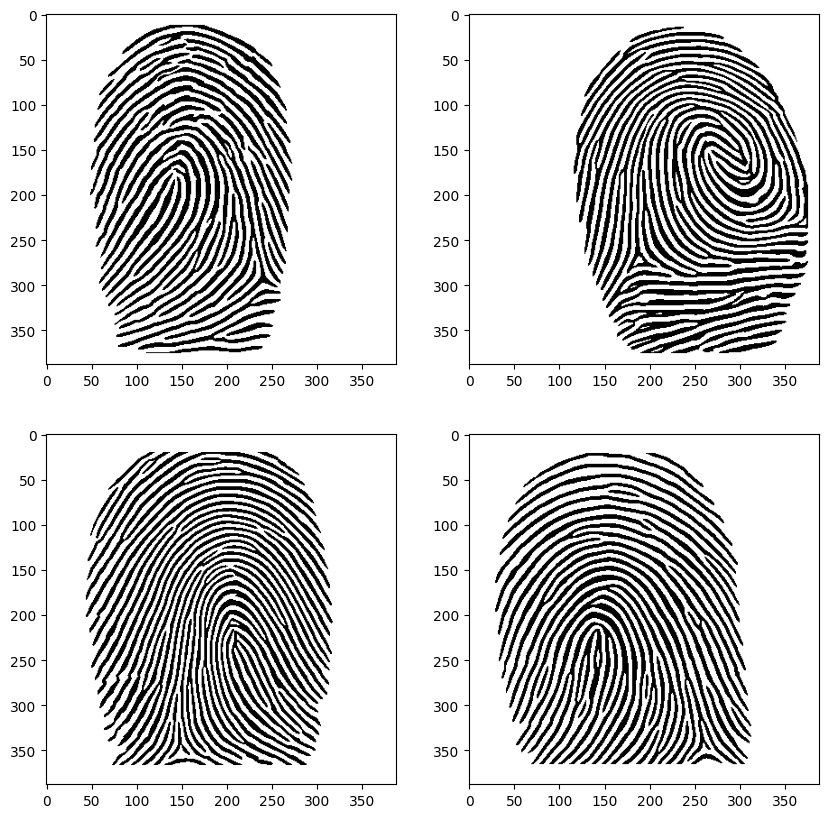

In [1]:
# Chargement des librairies
import numpy as np
import cv2
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.morphology import thin
import os

# Chargement des images de la base de données
path='./db_fbi/'
files = os.listdir(path)
files.append(files.pop(0))

images_db_fbi = []
for file in files:
   images_db_fbi.append(cv2.imread(path+file,0))

# Affichage des quelques images de la base de données
plt.close()
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images_db_fbi[i], cmap='gray')
plt.show()




b) La première étape est la skeletization, une opération de morphologie mathématique.

***En quoi consiste la skeletization ?***

***Réponse :***

- La squelettisation est un processus de transformation d'une image binaire en un squelette à largeur d'un pixel, conservant la structure et la connectivité essentielles de l'objet. Cela simplifie la forme originale, facilitant l'identification des caractéristiques clés comme les minutiae dans les empreintes digitales.

***Pourquoi est-il intéressant dans notre contexte de faire une skeletization :***

***Réponse :***

- Dans notre contexte, la squelettisation est intéressante car elle simplifie les empreintes en réduisant les crêtes à des lignes centrales d'un pixel de large. Cela facilite l'identification et l'extraction des minutiae (terminaisons et bifurcations), qui sont les points caractéristiques essentiels pour l'identification des empreintes. En simplifiant la structure de l'empreinte, la squelettisation améliore la précision et l'efficacité de la comparaison et de la correspondance des empreintes digitales.

L'opération étant un peu complexe à implémenter, on va utiliser une version déjà implémentée proposée par scikit-image. La fonction se nomme *thin*.

Prenez une image exemple de la base de données, appliquez une skeletization et affichez le résultat obtenu.

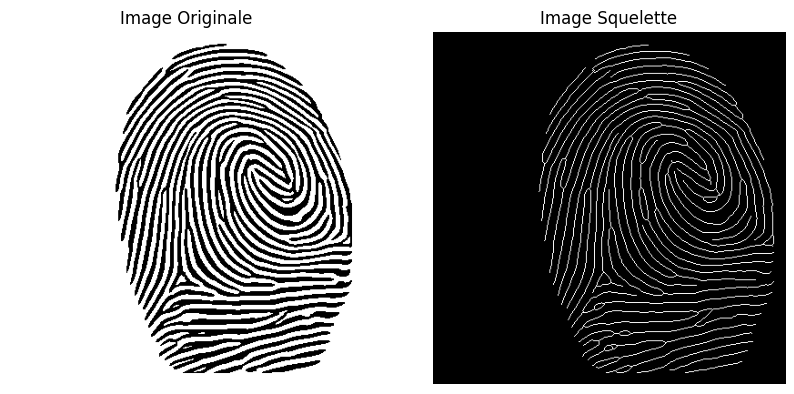

In [2]:
# Fonction de skeletization de l'image
def skeletization(image):
   
    # Inversion de l'image
    image_inverse = ~image
    
    # Application de la squelettisation
    squelette = thin(image_inverse)
    
    return squelette

exemple_image = images_db_fbi[1]

# Skeletization de l'image
squelette = skeletization(exemple_image)

# Affichage du résultat
plt.close()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(exemple_image, cmap='gray')
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(squelette, cmap='gray')
plt.title('Image Squelette')
plt.axis('off')
plt.show()


***Le résultat vous paraît-t-il satisfaisant ? Pour cela, comparez le résultat avec votre image originale.***

***Réponse :***

- Les lignes du squelette semblent suivre de manière assez précise l'empreinte digitale. Les formes sont bien reproduites.

- La structure globale de l'empreinte semble bien conservée dans le squelette. Les principales caractéristiques et motifs de l'empreinte digitale sont présents.

-  Le résultat semble satisfaisant.



c) C'est parti pour la détection ! Occupons-nous d'abord des terminaisons.

D'un point de vue local, un pixel est considéré comme une terminaison si et seulement si :
- Le pixel est blanc
- Un seul pixel dans son entourage (fenêtre 3x3) est blanc

Implémentez une fonction permettant de détecter les terminaisons (sous forme d'une matrice de taille Nx2 avec N le nombre de terminaisons et 2 les coordonnées dans l'image). Appliquez ensuite votre fonction sur votre image skeletizée.

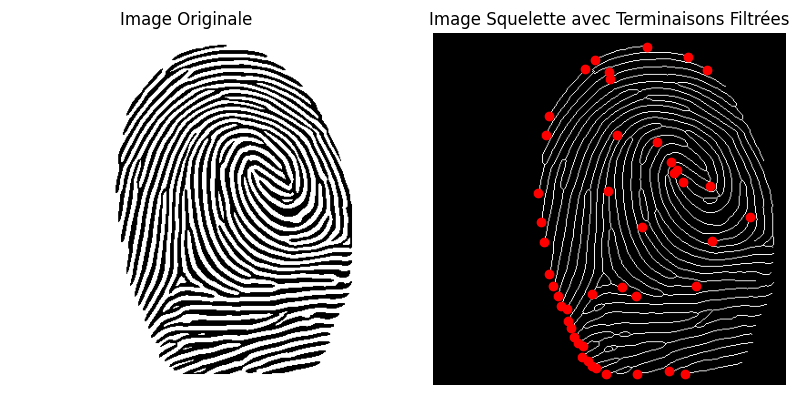

In [3]:
def detect_terminations(squelette):
    """
    Cette fonction détecte les terminaisons dans une image squelettisée.
    
    :param squelette: L'image squelettisée.
    :return: Une matrice Nx2 contenant les coordonnées des terminaisons.
    """
    terminations = []
    rows, cols = squelette.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if squelette[i, j] == 1:  # Vérifie si le pixel est blanc
                # Comptage des pixels blancs dans la fenêtre 3x3
                window = squelette[i-1:i+2, j-1:j+2]
                white_pixel_count = np.sum(window)
                
                if white_pixel_count == 2:  # Un seul autre pixel est blanc
                    terminations.append([i, j])
    
    return np.array(terminations)

def create_elliptical_mask(shape, center, axes, angle):
    """
    Crée un masque elliptique pour une image donnée.
    
    :param shape: La forme de l'image.
    :param center: Le centre de l'ellipse (x, y).
    :param axes: Les axes de l'ellipse (longueur, largeur).
    :param angle: L'angle de l'ellipse en degrés.
    :return: Un masque binaire avec une ellipse dessinée.
    """
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.ellipse(mask, center, axes, angle, 0, 360, 1, -1)
    return mask

def filter_terminations_by_mask(terminations, mask):
    """
    Filtre les terminaisons situées en dehors de la zone définie par le masque.
    
    :param terminations: Les coordonnées des terminaisons détectées.
    :param mask: Le masque binaire définissant la zone d'intérêt.
    :return: Les coordonnées des terminaisons filtrées.
    """
    filtered_terminations = []
    for y, x in terminations:
        if mask[y, x] == 1:  # Si le pixel est dans la zone d'intérêt
            filtered_terminations.append([y, x])
    
    return np.array(filtered_terminations)


# Appliquer la fonction de détection des terminaisons sur l'image squelettisée
terminations = detect_terminations(squelette)

# Définir la zone d'intérêt elliptique manuellement (centre, axes, angle)
center = (squelette.shape[1] // 2, squelette.shape[0] // 2)
axes = (int(squelette.shape[1] * 0.4), int(squelette.shape[0] * 0.6))
angle = 0

# Créer le masque elliptique
mask = create_elliptical_mask(squelette.shape, center, axes, angle)

# Filtrer les terminaisons en dehors de la zone d'intérêt elliptique
filtered_terminations = filter_terminations_by_mask(terminations, mask)

# Affichage du résultat avec les terminaisons marquées en rouge
plt.close()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(exemple_image, cmap='gray')
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(squelette, cmap='gray')
plt.title('Image Squelette avec Terminaisons Filtrées')
plt.axis('off')

# Marquer les terminaisons filtrées en rouge
for (y, x) in filtered_terminations:
    plt.plot(x, y, 'ro')

plt.show()








Il faut visualiser tout ça ! Pour cela, implémentez une fonction d'affichage prenant en entrée votre image d'origine et les terminaisons détectées. Votre fonction affichera l'image avec les terminaisons (en petits cercles rouge).

In [4]:
# Fonction d'affichage des terminaisons sur l'image d'origine
def plot_terminaisoterminaisons(image,terminaisons):

    plt.imshow(image, cmap='gray')
    plt.scatter(terminaisons[:, 1],terminaisons[:, 0], c='red', s=7)  # Affichage des terminaisons en rouge
    plt.title('Terminaisons Détectées')
    plt.axis('off')
    plt.show()

# Application de la fonction d'affichage sur votre image exemple
plot_terminaisoterminaisons(exemple_image,terminaisons)


NameError: name 'terminaisons' is not defined

***Les terminaisons détectées sont-elles correctes ?***

***Réponse :***  Oui, toutes les terminaisons sont détectées.



d) La fonction de détection des terminaisons fonctionne en l'état, mais ce sera beaucoup plus difficile pour les bifurcations. Pour palier à ce problème, on va utiliser une autre fonction connue de morphologie mathématique : Hit or Miss. Cette fonction permet de trouver des patterns particuliers sur une image. Pour cela, il faut définir un kernel défini de la manière suivante :
- Les valeurs du kernel à 1 doivent être blancs sur l'image
- Les valeurs du kernel à -1 doivent être noirs sur l'image
- Les valeurs du kernel à 0 peuvent être noirs ou blancs sur l'image

En appliquant ce kernel sur votre image, tous les pixels blancs seront ceux respectant les règles définies par le kernel. Les autres seront noirs.

Heureusement, OpenCV propose la fonction Hit Or Miss : https://docs.opencv.org/4.x/db/d06/tutorial_hitOrMiss.html

***En utilisant des kernels de taille 3x3, combien de kernels aura-ton besoin pour détecter tous les types de terminaisons ?***

***Réponse :***

- Pour détecter tous les types de terminaisons en utilisant des kernels de taille 3x3, nous devons considérer toutes les configurations possibles où un pixel blanc a exactement un seul voisin blanc dans une fenêtre 3x3. Il y a huit directions possibles pour ce voisin blanc (haut, bas, gauche, droite, et les quatre diagonales).

- Chaque configuration de terminaison correspond à une orientation différente, donc nous aurons besoin de 8 kernels pour détecter tous les types de terminaisons dans une image squelettisée.


Définissez les kernels qui seront utilisés pour la détection de terminaisons

*Note : Histoire de gagner du temps et de la lisibilité dans le code, vous pouvez utiliser la fonction rotate d'OpenCV, permettant de faire des rotations à 90°, 180° ou 270°*

In [ ]:
# Définition des kernels de base pour détecter les terminaisons
kernels = []

# Terminaison vers le bas
kernels.append(np.array([
    [0,  0, 0],
    [0,  1, 0],
    [-1, 1, -1]
], dtype=np.int8))

# Terminaison vers le haut
kernels.append(np.array([
    [-1, 1, -1],
    [0,  1, 0],
    [0,  0, 0]
], dtype=np.int8))

# Terminaison vers la droite
kernels.append(np.array([
    [0,  0, -1],
    [0,  1,  1],
    [0,  0, -1]
], dtype=np.int8))

# Terminaison vers la gauche
kernels.append(np.array([
    [-1, 0, 0],
    [ 1, 1, 0],
    [-1, 0, 0]
], dtype=np.int8))

# Terminaison diagonale haut-gauche
kernels.append(np.array([
    [0, 1, -1],
    [1, 1,  0],
    [-1, 0, 0]
], dtype=np.int8))

# Terminaison diagonale haut-droite
kernels.append(np.array([
    [-1, 1,  0],
    [0,  1,  1],
    [0, -1, 0]
], dtype=np.int8))

# Terminaison diagonale bas-droite
kernels.append(np.array([
    [0, -1, 0],
    [0,  1, 1],
    [-1, 1, 0]
], dtype=np.int8))

# Terminaison diagonale bas-gauche
kernels.append(np.array([
    [-1, 0, 0],
    [ 1,  1, 0],
    [0,  1, -1]
], dtype=np.int8))



Appliquez maintenant la morphologie mathématique Hit Or Miss d'OpenCV sur votre image skeletizée avec vos kernels. Récupérez ensuite les coordonnées des pixels blancs des images résultats, ce qui constituera votre matrice de terminaisons. Affichez ensuite ces terminaisons sur votre image d'origine et comparez les résultats par rapport à votre fonction de détection implémentée dans la partie b)

In [5]:
# A compléter
# Hit Or Miss sur l'image skeletizée avec les kernels de terminaisons
...

# Récupération des terminaisons détectées
...

# Affichage des terminaisons sur l'image d'origine
...

# Convertir l'image squelettisée en uint8 (type de données pris en charge par OpenCV)
squelette_conv = squelette.astype(np.uint8)*255

# Fonction pour appliquer la transformation Hit or Miss avec les kernels de terminaisons
def detect_terminations_hit_or_miss(skeleton, kernels):
    terminaisons = []
    for i, kernel in enumerate(kernels):
        hit_or_miss_result = cv.morphologyEx(skeleton, cv.MORPH_HITMISS, kernel)
        white_pixels = np.column_stack(np.where(hit_or_miss_result == 255))
        if white_pixels.size > 0:
            terminaisons.append(white_pixels)
        plt.imshow(hit_or_miss_result, cmap='gray')
        plt.title(f'Hit or Miss Result Kernel {i}')
        plt.show()
    
    if terminaisons:
        terminaisons = np.vstack(terminaisons)
    else:
        terminaisons = np.array([])

    print("Terminaisons détectées : ", terminaisons)
    return terminaisons

terminaisons = detect_terminations_hit_or_miss(squelette_conv, kernels)

# Fonction d'affichage des terminaisons sur l'image d'origine
def display_terminations(image, terminaisons):
    plt.imshow(image, cmap='gray')
    plt.scatter(terminaisons[:, 1], terminaisons[:, 0], color='red', s=10)
    plt.title('Image with Terminations')
    plt.show()

# Affichage des terminaisons détectées sur l'image d'origine
display_terminations(exemple_image, terminaisons)


NameError: name 'kernels' is not defined

***Le résultat obtenu est-il le même que celui obtenu avec votre précédente fonction de détection ?***

***Réponse :***

e) Passons aux bifurcations. Même principe que précédemment avec Hit Or Miss.

***Combien de kernels aura-ton besoin pour détecter tous les types de bifurcations ?***

***Réponse :***

Définissez les kernels qui seront utilisés pour la détection de bifurcations

In [ ]:
# A compléter
# Définition des kernels pour détecter les types de bifurcations
...

Ellipsis

Appliquez Hit Or Miss sur votre image skeletizée avec vos kernels. Récupérez ensuite les coordonnées des bifurcations. Affichez ensuite ces bifurcations sur votre image d'origine. Pour cela, modifiez votre fonction d'affichage pour afficher les terminaisons en rouge et les bifurcations en vert.

In [ ]:
# A compléter
# Hit Or Miss sur l'image skeletizée avec les kernels de bifurcations
...

# Récupération des bifurcations détectées
...

# Modification de la fonction d'affichage pour afficher différement les terminaisons (rouge) des bifurcations (verts)
...

# Affichage des terminaisons et des bifurcations sur l'image d'origine
...

Ellipsis

***Le résultat est-il satisfaisant ?***

***Réponse :***

Regroupez le code écrit précédemment pour implémenter une seule fonction qui détecte les terminaisons et bifurcations d'une image skeletizée. 

In [ ]:
# A compléter
# Fonction de détection des terminaisons et bifurcations
...

# Application sur votre image skeletizée
...

# Affichage des résultats
...

Ellipsis

f) Afin de mieux décrire les terminaisons et bifurcations détectées, vous allez ajouter aux informations de localisation (coordonnées cartésiennes), des informations d'orientation. Une terminaison a une seule orientation alors qu'une bifurcation en a trois. Dès lors, les terminaisons T et bifurcation B auront la forme suivante :

- $T_{i} = \{x_{i},y_{i},\theta_{i}\}$
- $B_{i} = \{x_{i},y_{i},\theta^{1}_{i},\theta^{2}_{i},\theta^{3}_{i}\}$

Pour définir les orientations, on caractérisera $\theta$ sous forme d'angle en radians en fonction du cercle trigonométrique

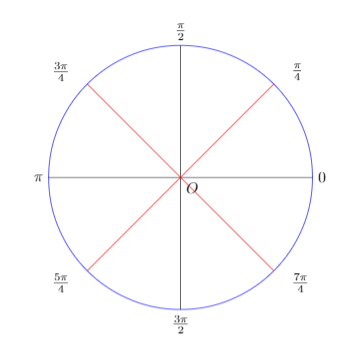

Modifiez votre fonction de détection des terminaisons et bifurcations afin de calculer leurs orientations. Les matrices de terminaisons et bifurcations seont respectivement de taille Nx3 et Mx5 avec N et M les nombres de terminaisons et bifurcations trouvées. Appliquez votre fonction sur votre image skeletizée.

*Note : Pour la suite du TP, il faut que les orientations des bifurcations soient triées dans l'ordre croissant*

In [ ]:
# A compléter
# Fonction de détection des terminaisons et bifurcations et calcul de leur orientation
def orientation_minutiae(skel_img, terms, bifs):
    """
        Calcule les orientations des terminaisons et bifurcations d'une empreinte.

        Arguments:
            skel_img : l'image skeletizée de l'empreinte
            terms (nd.array Nx2): les coordonnées des terminaisons détectées de l'empreinte
            bifs (nd.array Mx3): les coordonnées des terminaisons détectées de l'empreinte

        Retourne :
            terms (nd.array N'x3): les coordonnées et l'orientation des terminaisons détectées de l'empreinte
            bifs (nd.array M'x5): les coordonnées et les trois orientations des bifurcations détectées de l'empreinte
    """
    h_b,_ = bifs.shape
    h_t,_ = terms.shape
    h_I,w_I = skel_img.shape

    bifs_x = bifs[:,0]
    bifs_y = bifs[:,1]
    terms_x = terms[:,0]
    terms_y = terms[:,1]

    # Initialisation des matrices des orientations des minutiaes
    orient_terms = np.ones(terms_x.shape)*-10
    orient_bifs = np.ones((len(bifs_x),3))*-10

    # Définition des angles d'orientations dans la fenêtre 3x3
    table = np.array([[3*np.pi/4,np.pi/2,np.pi/4],
                      [np.pi,0,0],
                      [5*np.pi/4,3*np.pi/2,7*np.pi/4]])

    # Calcul des orientations des terminaisons
    for i in range(h_t):
        if (1<terms_x[i]<h_I-2) & (1<terms_y[i]<w_I-2):
            # Sélection de la fenêtre 3x3 centrée sur la terminaison
            K_local = skel_img[terms_x[i]-1:terms_x[i]+2,terms_y[i]-1:terms_y[i]+2].copy()
            # Mise à zéro du centre dans la fenêtre
            K_local[1,1] = 0
            # Récupération des coordonnées du pixel blanc dans la fenêtre
            arg_k = np.argwhere(K_local)
            # Calcul de l'angle de la terminaison à partir de ses coordonnées
            orient_terms[i] = table[arg_k[0,0],arg_k[0,1]]

    # Calcul des orientations des bifurcations
    for i in range(h_b):
        if (1<bifs_x[i]<h_I-2) & (1<bifs_y[i]<w_I-2):
            # Sélection de la fenêtre 3x3 centrée sur la bifurcation
            K_local = skel_img[bifs_x[i]-1:bifs_x[i]+2,bifs_y[i]-1:bifs_y[i]+2].copy()
            # Mise à zéro du centre dans la fenêtre
            K_local[1,1] = 0
            # Récupération des coordonnées du pixel blanc dans la fenêtre
            arg_k = np.argwhere(K_local)
            #if K_local.sum()==3:
            # Calcul des angles de la bifurcations à partir des coordonnées
            orient_bifs[i]=np.sort([table[arg_k[j,0],arg_k[j,1]] for j in range(3)])

    # Suppression des minutiaes invalides
    ind_keep_bifs = orient_bifs[:,0]!=-10
    orient_bifs = orient_bifs[ind_keep_bifs]
    bifs = bifs[ind_keep_bifs]

    ind_keep_terms = orient_terms!=-10
    orient_terms = orient_terms[ind_keep_terms]
    terms = terms[ind_keep_terms]

    # Concatenation des minutiaes avec leur orientation calculée
    terms = np.concatenate([terms,np.expand_dims(orient_terms,-1)],axis=-1)
    bifs = np.concatenate([bifs,orient_bifs],axis=-1)

    return terms, bifs
# Application sur l'image skeletizée
...

Ellipsis

Afin de vérifier que votre implémentation est correcte, affichez-moi l'affichage local d'une terminaison et d'une bifurcation (fenêtre 3x3 de l'image centrée sur la minutiae), ainsi que les orientations calculées de ces deux minutiaes

In [ ]:
# A compléter
# Affichage de la fenêtre 3x3 d'une terminaison
...

# Affichage de l'orientation de la terminaison
...

# Affichage de la fenêtre 3x3 d'une bifurcation
...

# Affichage des orientations de la bifurcation
...

Ellipsis

g) La fonction de détection est correcte, mais comporte un soucis majeur : beaucoup de minutiaes détectées ne sont pas des caractéristiques de l'empreinte. Elles sont à la limite de l'empreinte, et sont donc liées au champ de capture de l'empreinte. De ce fait, en comparant deux mêmes empreintes mais avec un différent champ de captation, on verra les mêmes minutiaes au centre, mais des minutiaes totalement différentes. Il faut donc supprimer les minutiaes situées en périphérie de l'empreinte

Tout d'abord, effecutez une détection de contours sur l'image originale. Attention : il faut inverser les couleurs en amont (sillures en blanc). Affichez l'image originale avec les contours dessinés en vert

In [ ]:
# A compléter
# Détection des contours 
...

# Affichage de l'image avec les contours dessinés
...

Ellipsis

Ensuite, on va définir le contour convexe de cet ensemble de contours. Un contour convexe est un contour fermé dont tous les angles sont inférieurs à 180°. L'objectif est donc d'avoir un contour qui englobe tous les autres contours, définissant ainsi notre empreinte. Pour cela, on va utiliser la fonction convexHull d'OpenCV. 

Transformez vos contours (actuellement en tuple) en liste, concatenez les (via la fonction concatenate de Numpy), et calculez le contour convexe. Reprenez l'image précédente avec les contours dessinés en vert et tracez le contour convexe en rouge

In [ ]:
# A compléter
# Calcul du contour convexe à partir des différents contours détectés
...

# Affichage de l'image avec les contours dessinés (vert) et le contour convexe (rouge)
...

Ellipsis

A partir de contour convexe, créez un masque, où tous les pixels à l'intérieur du polygone convexe sont blancs et les autres noirs. Pour cela, utilisez la fonction drawContours d'OpenCV, en indiquant l'option pour remplir le contour. Affichez le masque obtenu

In [ ]:
# A compléter
# Création du masque convexe
...

# Affichage du masque convexe
...

Ellipsis

Ce masque ici définit les pixels considérés comme dans le champ de captation de l'empreinte. On va donc réduire cette zone afin par la suite de filtrer les minutiaes situées sur le bord du champ de captation. Pour cela, effectuez une érosion de ce masque avec un kernel elliptique de taille 15x15. Affichez le masque obtenu

In [ ]:
# A compléter
# Erosion du masque convexe
...

# Affichage du masque convexe érodé
...

Ellipsis

Pour finir, filtrez vos terminaisons et bifurcations détectées en ne sélectionnant que ceux inclus dans le masque convexe érodé (via leurs coordonnées cartésiennes). Affichez l'image originale avec les terminaisons et bifurcations filtrées

In [ ]:
# A compléter
# Filtrage des terminaisons et bifurcations inclus dans le masque convexe érodé
...

# Affichage de l'image originale avec les terminaisons et bifurcations filtrées
...

Ellipsis

Regroupez tout le code précédent pour faire une fonction de filtrage des minutiaes prenant en entrée l'image originale, les terminaisons et bifurcations détectées et qui retournera les minutiaes filtrées

In [ ]:
# A compléter
# Fonction de filtrage des minutiaes
...

Ellipsis

h) Voilà tout ! La fonction de détection est opérationnelle ! Implémentez une fonction globale qui détecte toutes les terminaisons à partir de l'image originale et effectue le filtrage pour supprimer les minutiaes en dehors du champ de captation. Calculez ensuite les minutiaes de toutes les images de la base de données *DB_FBI* et stockez les informations dans un dictionnaire (clé : nom du suspect, valeur : terminaisons et bifurcations de l'image calculée). Enfin, affichez quelques images de la base de données avec les minutiaes détectées.

In [ ]:
# A compléter
# Fonction globale de détection des minutiaes à partir de l'image originale
...

# Calcul des minutiaes sur toutes les images de la base de données et stockage dans un dictionnaire
...

# Affichage de plusieurs images de la base de données avec les minutiaes détectées
...

Ellipsis

---

## 2) C'est du propre !



Il faut maintenant s'attaquer aux images prélevées sur la scène de crime. Malheureusement, elles ne sont pas d'aussi bonne qualité que les images de la base de données du FBI. Il est donc nécessaire de les pré-traiter.

Chargez et affichez l'image du suspect

In [ ]:
# A compléter
# Chargement de l'image du suspect
...

# Affichage de l'image du suspect
...

Ellipsis

A vous de prétraiter l'image, pas d'indications ! Pour cela, vous pouvez utiliser ce que vous avez vu en TD et TP précédemment, mais aussi aller chercher d'autres méthodes pouvant répondre à vos problématiques. 

Dans un premier temps, analysez votre image afin d'identifier les problèmes. A travers les problèmes identifiés, proposez votre processus de prétraitement pour résoudre ces problèmes en justifiant vos choix. L'image finale devra être binarisée. Enfin, analysez de manière objective votre processus de prétraitement en précisant les points positifs et points d'amélioration.

*Note : n'hésitez pas à afficher les résultats intermédiaires ! Et surtout, commentez votre code !*

*Note 2 : il est difficile de trouver des méthodes permettant de résoudre vos problèmes si vous ne les connaissez pas. C'est là qu'un outil comme ChatGPT est intéressant. Si vous lui décrivez bien les problèmes de l'image, il peut vous trouver des solutions adaptées. Le plus important est de bien décrire ce que vous constatez. Si je vous précise ça, c'est que je vous autorise, voire conseille de l'utiliser*

***Analyse de l'image et identification des problèmes :***

***Présentation du processus de prétraitement avec justification des choix :***

In [ ]:
# A compléter
# Implémentation du processus de prétraitement
...

# Affichage de l'image prétraitée
...

Ellipsis

***Analyse de votre processus de prétraitement :***

Détectez maintenant les minutiaes avec votre image suspect prétraitée, et affichez le résultat.

In [ ]:
# A compléter
# Détection des minutiaes sur l'image suspect
...

# Affichage de l'image suspect originale avec les minutiaes détectées
...

Ellipsis

***Le résultat est-il satisfaisant ?***

***Réponse :***

---

## 3) Ca matche ou ça casse

Vous avez détecté les minutiaes des empreintes, il est l'heure maintenant d'identifier les malfrats. Pour se faire, on va comparer les caractéristiques des empreintes révélées sur la scène de crime avec celles de la base de données. Cette étape n'est pas facile : on a des nuages de points qui dépendent beaucoup de la qualité des traitements précédents. De plus, les empreintes récoltées ne sont pas de même taille, dans la même direction, ni positionnées au même endroit dans l'image. Bref, c'est la galère.

Heureusement, je vous fournis un code, permettant de faire ce matching :

In [ ]:
import numpy as np
from itertools import product
from scipy.optimize import linear_sum_assignment

def center_points_on_index(M, i, angle_index):
    """
    Centre les points de la matrice M autour du point d'indice i, en tenant compte de l'angle.

    Args:
        M (np.ndarray): Matrice de points de taille Nx3 avec x, y et angle.
        i (int): Indice du point autour duquel centrer.
        angle_index (int): Indice de l'angle à utiliser pour la rotation.

    Returns:
        np.ndarray: Matrice centrée avec les points ajustés.
    """
    angle_i = M[i, 2 + angle_index]  # Angle du point d'indice i

    # Matrice de rotation basée sur l'angle
    R = np.array([[np.cos(angle_i), np.sin(angle_i)],
                  [-np.sin(angle_i), np.cos(angle_i)]])
    
    B = np.zeros_like(M)  # Matrice pour les points centrés et ajustés
    B[:, :2] = np.dot(M[:, :2] - M[i, :2], R.T)  # Appliquer la rotation et centrer
    B[:, 2:] = np.sort((M[:, 2:] - angle_i) % (2 * np.pi), axis=1)  # Ajuster les angles

    return B

def rotate_points(M, alpha):
    """
    Applique une rotation d'angle alpha aux points de la matrice M.

    Args:
        M (np.ndarray): Matrice de points de taille Nx3 avec x, y et angle.
        alpha (float): Angle de rotation en radians.

    Returns:
        np.ndarray: Matrice des points après rotation.
    """
    # Matrice de rotation basée sur l'angle alpha
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]])
    
    B = np.zeros_like(M)  # Matrice pour les points après rotation
    B[:, :2] = np.dot(M[:, :2], R.T)  # Appliquer la rotation
    B[:, 2:] = M[:, 2:] + alpha  # Ajuster les angles

    return B

def score(T1, T2, w_cartesian=1.0, w_angular=1.0, w_dif=1.0):
    """
    Calcule la matrice de coût basée sur les distances cartésiennes et angulaires entre deux ensembles de points.

    Args:
        T1 (np.ndarray): Premier ensemble de points Nx3 (terminaisons) ou Nx5 (bifurcations).
        T2 (np.ndarray): Deuxième ensemble de points Mx3 (terminaisons) ou Mx5 (bifurcations).
        w_cartesian (float): Poids pour la distance cartésienne.
        w_angular (float): Poids pour la distance angulaire.
        w_dif (float): Poids pour les points sans correspondance.
    Returns:
        tuple: Coût moyen des correspondances et les indices des correspondances optimales (row_ind, col_ind).
    """

    # On inverse l'ordre des matrices si besoin afin qu'il y ait autant ou plus de points dans T1 que dans T2
    if T1.shape[0] < T2.shape[0]:
        tmp = T1.copy()
        T1 = T2.copy()
        T2 = tmp

    # Distance cartésienne entre les points   
    T1x = T1[:, 0].reshape(-1, 1)
    T1y = T1[:, 1].reshape(-1, 1)
    T2x = T2[:, 0]
    T2y = T2[:, 1]
    dx = T1x - T2x
    dy = T1y - T2y
    cartesian_distance = np.sqrt(dx**2 + dy**2)  # Distance euclidienne

    # Distance angulaire entre les orientations des points
    angular_distance = np.zeros_like(cartesian_distance)
    for i in range(T1.shape[1] - 2):
        T1theta = T1[:, 2 + i].reshape(-1, 1)
        T2theta = T2[:, 2 + i]
        diff = np.abs(T1theta - T2theta) % (2 * np.pi)
        angular_distance += np.minimum(diff, 2 * np.pi - diff)  # Différence minimale en considérant la périodicité

    # Calcul de la matrice de coût
    cost_matrix = w_cartesian * cartesian_distance + w_angular * angular_distance

    # Ajout de la possibilité de non match en étendant cost_matrix
    no_match_cost_matrix = np.ones_like(cost_matrix)*w_dif
    cost_matrix = np.concatenate([cost_matrix,no_match_cost_matrix],axis=1)


    # Algorithme de Hongrie pour trouver le meilleur appariement
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Coût moyen des correspondances
    mean_cost = cost_matrix[row_ind, col_ind].mean()
    col_ind[col_ind>=T2.shape[0]]=-1

    return mean_cost, row_ind, col_ind


def match(M1, M2, w_cartesian=1.0, w_angular=1.0, w_dif=10.0):
    """
    Trouve le meilleur appariement entre deux ensembles de points en minimisant le coût.

    Args:
        M1 (np.ndarray): Premier ensemble de points de taille Nx3 (terminaisons) ou Nx5 (bifurcations).
        M2 (np.ndarray): Deuxième ensemble de points Mx3 (terminaisons) ou Mx5 (bifurcations).
        w_cartesian (float): Poids pour la distance cartésienne.
        w_angular (float): Poids pour la distance angulaire.
        w_dif (float): Poids pour les points sans correspondance.

    Returns:
        tuple: Coût minimal trouvé pour l'appariement et les correspondances optimales.
    """
    count1 = M1.shape[0]
    count2 = M2.shape[0]
    nb_angles = M1.shape[1] - 2

    if count1 > 0 and count2 > 0:
        # Centrage et ajustement des points
        T1 = np.array([center_points_on_index(M1, i, j) for i, j in product(range(count1), range(nb_angles))])
        T2 = np.array([center_points_on_index(M2, i, j) for i, j in product(range(count2), range(nb_angles))])
        
        # Initialisation des variables pour le coût minimal et les correspondances optimales
        min_cost = float('inf')
        best_row_ind = None
        best_col_ind = None

        # Calcul du coût minimal entre toutes les paires de points centrés et ajustés
        for i, j in product(range(T1.shape[0]), range(T2.shape[0])):
            cost, row_ind, col_ind = score(T1[i], T2[j], w_cartesian, w_angular, w_dif)
            if cost < min_cost:
                min_cost = cost
                best_row_ind = row_ind
                best_col_ind = col_ind
        
        return min_cost, best_row_ind, best_col_ind
    else:
        # Si l'un des ensembles est vide, le coût est basé sur la différence de taille des ensembles
        return w_dif * (count1 + count2), None, None

Le code précédent va tenter de faire correspondre au mieux les terminaisons ou bifurcations de deux empreintes. Ces correspondances vont se faire en essayant de répondre au mieux aux conditions suivantes :
- La distance entre les points matchés doit être le plus faible possible
- La distance angulaire des orientations des terminaisons et bifurcations doit être la plus faible possible

A l'issue de cette estimation, on va calculer un score de match indiquant la qualité des correspondances effectuées. Plus le score est faible, plus les empreintes sont proches, et inversement. 

Vous pouvez pondérer le score avec 3 facteurs à votre disposition :
- w_cartesian : le poids de la distance cartésienne entre les correspondances
- w_angular : le poids de la distance angulaire entre les orientations des correspondances
- w_dif : le poids des points sans correspondance

Plus un facteur est gros par rapport aux autres, plus son influence modifiera le score est ainsi les correspondances effectuées.

Cet appariement peut être assez long, donc j'ai optimisé au maximum le code pour éviter que vous attendiez les résultats pendant une demi-heure. Complétez le code suivant en fonction des indications pour pouvoir ensuite faire le matching.

In [ ]:
# A compléter
import concurrent
import progressbar

terminaisons_suspect = ... # Terminaisons de l'empreinte du suspect (Tableau Nx3)
biffucartions_suspect = ... # Bifurcations de l'empreinte du suspect (Tableau Mx5)

nom_suspects = ... # Liste des noms des suspects

terminaisons_FBI = ... # Terminaisons des empreintes de la base de données du FBI (Dictionnaire de tableaux Nx3 avec nom des suspects en clé)
biffucartions_FBI = ... # Bifurcations des empreintes de la base de données du FBI (Dictionnaire de tableaux Mx5 avec nom des suspects en clé)

def compute_score(params):
    k, terms, biffs, terms2, biffs2 = params
    score_terms, row_ind_terms, col_ind_terms = match(terms, terms2)
    score_biffs, row_ind_biffs, col_ind_biffs = match(biffs, biffs2)
    return {
        'id':k,
        'score':score_terms+score_biffs,
        'terms_match':np.stack([row_ind_terms,col_ind_terms]),
        'biffs_match':np.stack([row_ind_biffs,col_ind_biffs])
    }


# Création de la barre de progression
progress = progressbar.ProgressBar(max_value=len(terminaisons_FBI.keys()))

matching_result = {}

# Utilisation de ThreadPoolExecutor pour paralléliser le calcul des scores
with concurrent.futures.ThreadPoolExecutor() as executor:
    params = {k:(k,terminaisons_FBI[k],biffucartions_FBI[k],terminaisons_suspect,biffucartions_suspect) for k in nom_suspects}
    future_to_key = {executor.submit(compute_score, params[k]): k for k in nom_suspects}
    
    for future in progress(concurrent.futures.as_completed(future_to_key)):
        res = future.result()
        matching_result[res['id']] = res

ModuleNotFoundError: No module named 'progressbar'

Vous avez ci-dessous une fonction qui affiche les correspondances de terminaisons et bifurcations trouvées entre 2 images.

In [ ]:
import cv2
from matplotlib import pyplot as plt

def plot_matching(img1, img2, terms1, terms2, biffs1, biffs2, terms_match, biffs_match):
    """
    Affiche les correspondances entre deux images en utilisant des points d'intérêt (termes et bifurcations).

    Args:
        img1 (np.ndarray): Première image en niveaux de gris.
        img2 (np.ndarray): Deuxième image en niveaux de gris.
        terms1 (np.ndarray): Points d'intérêt (terminaisons) de la première image, de taille Nx2.
        terms2 (np.ndarray): Points d'intérêt (terminaisons) de la deuxième image, de taille Mx2.
        biffs1 (np.ndarray): Points d'intérêt (bifurcations) de la première image, de taille Px2.
        biffs2 (np.ndarray): Points d'intérêt (bifurcations) de la deuxième image, de taille Qx2.
        terms_match (np.ndarray): Correspondances entre les terminasons des deux images, de taille 2xK.
        biffs_match (np.ndarray): Correspondances entre les bifurcations des deux images, de taille 2xL.

    Returns:
        None: Affiche les images fusionnées avec les correspondances marquées.
    """

    # Récupération des dimensions de la première image
    h, w = img1.shape

    # Fusion des deux images côte à côte et conversion en couleur
    fused_img = cv2.cvtColor(np.concatenate([img1, img2], axis=1), cv2.COLOR_GRAY2RGB)

    # Affichage des points d'intérêt (terminaisons) de la première image en rouge
    if terms1 is not None:
        for t in terms1:
            cv2.circle(fused_img, (int(t[1]), int(t[0])), 2, (255, 0, 0), -1)

    # Affichage des points d'intérêt (bifurcations) de la première image en vert
    if biffs1 is not None:
        for b in biffs1:
            cv2.circle(fused_img, (int(b[1]), int(b[0])), 2, (0, 255, 0), -1)

    # Affichage des points d'intérêt (terminaisons) de la deuxième image en rouge
    if terms2 is not None:
        for t in terms2:
            cv2.circle(fused_img, (int(t[1]) + w, int(t[0])), 2, (255, 0, 0), -1)

    # Affichage des points d'intérêt (bifurcations) de la deuxième image en vert
    if biffs2 is not None:
        for b in biffs2:
            cv2.circle(fused_img, (int(b[1]) + w, int(b[0])), 2, (0, 255, 0), -1)

    # Affichage des lignes de correspondances pour les terminaisons en bleu
    if terms_match is not None:
        for i in range(terms_match.shape[1]):
            j, k = terms_match[:, i]
            cv2.line(fused_img, (int(terms1[j, 1]), int(terms1[j, 0])), (int(terms2[k, 1]) + w, int(terms2[k, 0])), (0, 0, 255), 1)

    # Affichage des lignes de correspondances pour les bifurcations en jaune
    if biffs_match is not None:
        for i in range(biffs_match.shape[1]):
            j, k = biffs_match[:, i]
            cv2.line(fused_img, (int(biffs1[j, 1]), int(biffs1[j, 0])), (int(biffs2[k, 1]) + w, int(biffs2[k, 0])), (255, 255, 0), 1)

    # Affichage de l'image avec les correspondances tracées
    plt.figure(figsize=(10, 5))
    plt.imshow(fused_img)
    plt.show()


Utilisez cette fonction pour afficher les correspondances trouvées entre votre image du coupable et celle du suspect le plus probable de votre base de données.

In [ ]:
# A compléter
# Affichage des correspondances entre les 2 images
...

***Est-ce que ce résultat de correspondances vous paraît satisfaisant ?***

***Réponse :***

***Qui est donc le coupable selon vous ?***

***Réponse :***

---

***Compte-rendu du lieutenant Peralta***

*"Nous avons interrogé des témoins qui étaient sur la scène de crime au moment des faits. Il se trouve que les 5 individus, âgés entre 20 et 30 ans, dinaient dans le restaurant Carmichaels à l'angle de la 5ème avenue et de la 36ème rue Ouest dans Manhattan. Rien n'est à signalé durant le diner, malgré que l'un d'entre eux a dragué assez lourdement la serveuse. C'est après avoir payé l'addition que l'un des individus a volé le cor de chasse bleu accroché au mur du restaurant. Les motivations qui ont menés à ce vol restent encore inconnus à ce jour."*